In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns
from sklearn.preprocessing import Imputer

sns.set_style('white')
sns.set_context('talk')

C:\Users\cwhar_000\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
combine_table = pd.read_csv('./data/combines.csv')
draft_table = pd.read_csv('./data/drafts.csv')
college_table = pd.read_csv('./data/college_stats.csv')

In [3]:
# just do w/e sean does but python"ish" but use method chaining a lot because...uhhh...w/e
left = (draft_table.loc[:, ['year', 'round', 'pick',
                            'team', 'player', 'college',
                            'pos', 'age', 'carav',
                            'drav', 'url']]
                   .assign(key=lambda df: ['{0}-{1}'.format(p,y) if pd.isnull(u) else u
                                           for u,p,y in df[['url', 'player', 'year']].values]))

# use key as URL and fill NaN with player-year
right = (combine_table.loc[:, ['year', 'player', 'pos',
                               'college', 'height', 'weight',
                               'forty', 'vertical', 'broad',
                               'bench', 'threecone', 'shuttle',
                               'url']]
                      .rename(columns={'year': 'year_combine',
                                       'player': 'player_combine',
                                       'pos': 'pos_combine',
                                       'college': 'college_combine',
                                       'url': 'url_combine'})
                      .assign(key=lambda df: ['{0}-{1}'.format(p,y) if pd.isnull(u) else u
                                              for u,p,y in df[['url_combine',
                                                               'player_combine',
                                                               'year_combine']].values]))

# filter down to get one row per player (we just throw away the dupe rows, bummer for you fellas!) 
right = right.groupby('key').first().reset_index()

# slow but clear implementation of coalesce
def coalesce(values):
    try:
        return next(e for e in values if not pd.isnull(e))
    except:
        return None

def resolve_columns(columns):
    '''take a numpy array and coalesce each row'''
    return np.apply_along_axis(coalesce, 1, columns)

# let's even test this shit to see if it's robust to the three types of NaN we might see in the dataframe!
assert coalesce([None, float('nan'), np.nan, 6, 7]) == 6
# and test the case for all None
assert pd.isnull(coalesce([None, float('nan'), np.nan]))

# join them up
combined = (left.merge(right, how='outer', on='key')
                .assign(player=lambda df: resolve_columns(df[['player', 'player_combine']]),
                        pos=lambda df: resolve_columns(df[['pos', 'pos_combine']]),
                        college=lambda df: resolve_columns(df[['college', 'college_combine']]),
                        year=lambda df: resolve_columns(df[['year', 'year_combine']]),
                        url=lambda df: resolve_columns(df[['url', 'url_combine']])))

# to long for stats merge
training = (combined.loc[:, ['key', 'carav', 'height',
                             'weight', 'forty', 'vertical',
                             'bench', 'age', 'threecone',
                             'shuttle', 'broad']]
                    .assign(height=lambda df: [float('nan') if pd.isnull(x)
                                               else 12.0 * int(x.split('-')[0]) + int(x.split('-')[1])
                                               for x in df.height]))

# Looking at this now I don't get the wide to long, drop na, back to wide, impute, back to long
# seems like you could just done set_index key, impute, wide to long *shrug*
training = (pd.melt(training, id_vars=['key'], value_vars=['carav', 'height', 'weight',
                                                           'forty', 'vertical', 'bench',
                                                           'age', 'threecone', 'shuttle',
                                                           'broad'])
              .dropna()
              .pivot_table(values='value', index='key', columns='variable'))

# Impute with median (no fancy mice right now)
# And yes, we're cheating by imputing before train/test split but YOLOLOLOLOLOL
training.loc[:,['height', 'weight', 'forty',
                'vertical', 'bench', 'age',
                'threecone', 'shuttle','broad']] = (Imputer(strategy='median')
                                                    .fit_transform(training[['height', 'weight', 'forty',
                                                                             'vertical', 'bench', 'age',
                                                                             'threecone', 'shuttle','broad']]))

# Back to long
training = pd.melt(training.reset_index(), id_vars=['key'], value_vars=['carav', 'height', 'weight',
                                                                        'forty', 'vertical', 'bench',
                                                                        'age', 'threecone', 'shuttle',
                                                                        'broad'])

# college stats
college_stats = (college_table.groupby(['url','stat'])
                              .first()
                              .reset_index()
                              .rename(columns={'url': 'key', 'stat': 'variable'})
                              .drop('section', axis=1)
                              .assign(variable=lambda df: [x.replace('.', '_') for x in df.variable]))

# smash onto the end of training and reshape
college_stats = (pd.concat([training, college_stats])
                   .pivot_table(values='value', index='key', columns='variable', fill_value=0))

# Add back in categoricals
training_data = (combined[['key', 'player', 'pick', 'pos', 'college', 'year', 'team']]
                 .merge((combined.groupby('college').player
                         .aggregate(len)
                         .reset_index()
                         .rename(columns={'player': 'n_college_picks'})))
                         .assign(short_college=lambda df: ['SMALL SCHOOL' if np < 50 else c for np, c in df[['n_college_picks',
                                                                                                             'college']].values],
                                 pick=lambda df: [257 if pd.isnull(x) else x for x in df.pick.values])
                         .set_index('key')
                         .merge(college_stats, left_index=True, right_index=True, how='inner')
                         .reset_index()
                         .fillna('None'))  # team has NaN make it string None

 # Split it up
rng = np.random.RandomState(67)
pre_2016_rows = training_data.index.values[(training_data['year'] < 2016).values]
training_set_rows = rng.choice(pre_2016_rows, size=int(0.9 * len(pre_2016_rows)), replace=False)
validation_set_rows = np.array(list(set(pre_2016_rows).difference(set(training_set_rows))))
test_set_rows = training_data.index.values[~(training_data['year'] < 2016).values]

# targets
pick = training_data.pick.values
carav = training_data.carav.values
first_round = (pick <= 32).astype(int)

# Whew...

In [4]:
## Feature engineering

# columns we don't want as inputs
exclude_columns = ['key', 'pick', 'player', 'college', 'year', 'team', 'n_college_picks']

# One-hot the two categorical columns
# Bit of cheating here too because we add columns for data possibly not found in training
# but they are likely to get zero weight
training_features = (pd.get_dummies(training_data, columns=['pos', 'short_college'], drop_first=True)
                     .drop(exclude_columns, axis=1))

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve

In [6]:
lr_model = LogisticRegressionCV(cv=5, class_weight='balanced', verbose=1, max_iter=500, solver='liblinear', n_jobs=-1)
lr_model.fit(training_features.ix[training_set_rows, :].as_matrix(), first_round[training_set_rows])

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=500,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=1)

In [17]:
feature_weights = pd.DataFrame(list(zip(training_features.columns.values, lr_model.coef_[0])), columns=['feature_name', 'weight'])

In [7]:
predictions = lr_model.predict_proba(training_features.as_matrix())[:,1]
roc_auc_score(first_round[validation_set_rows], predictions[validation_set_rows])

0.90707493613397672

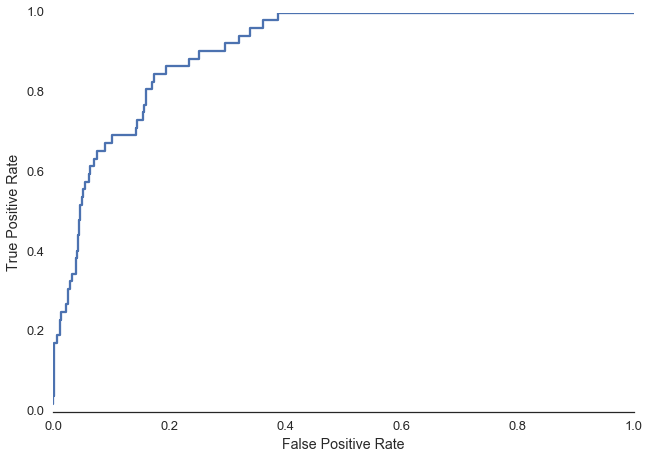

In [22]:
fpr, tpr, thresholds = roc_curve(first_round[validation_set_rows], predictions[validation_set_rows], pos_label=1)
plt.plot(fpr, tpr)
sns.despine(left=True)
plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')

In [19]:
feature_weights.sort_values(by='weight').head(5)

,feature_name,weight
9,forty,-1.146214
123,short_college_SMALL SCHOOL,-0.823177
1,age,-0.521957
77,pos_LB,-0.343647
61,threecone,-0.334020


In [20]:
feature_weights.sort_values(by='weight').tail(5)

,feature_name,weight
100,short_college_Florida,0.366887
33,punt_return_td,0.423924
87,pos_T,0.447743
109,short_college_Miami (F,0.499038
68,pos_DB,0.605095
